In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
aci_df = pd.read_csv('../data/aci_curve_data.csv')

aci_df = aci_df[~aci_df['which_400'].isin(['first', 'second', 'fourth', 'fifth'])]
# aci_df = aci_df[aci_df['line'].isin(['1.10.18', 'wt'])]

grouped_df = aci_df.groupby(['CO2_r_sp', 'line']).agg({'A': ['mean', 'std'], 'Ci': ['mean', 'std']})
grouped_df.columns = ['A_mean', 'A_std', 'Ci_mean', 'Ci_std']
grouped_df = grouped_df.reset_index()

for col in aci_df.columns:
    print(col)
for col in grouped_df.columns:
    print(col)

plant
line
Ci
CO2_r_sp
A
time
date
licor
time_period
light
Order
which_400
CO2_r_sp
line
A_mean
A_std
Ci_mean
Ci_std


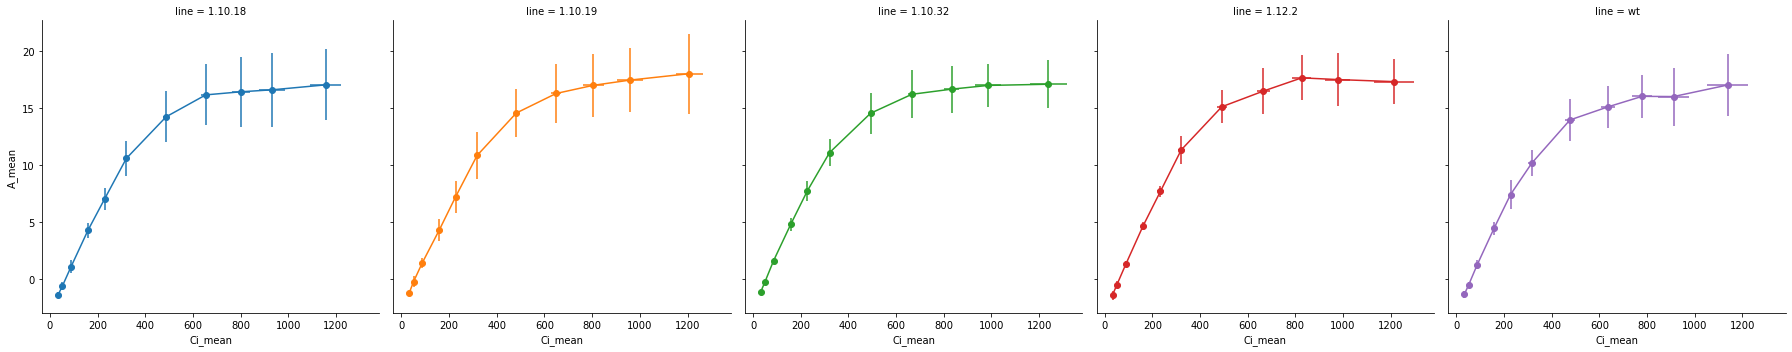

In [31]:
g = sns.FacetGrid(grouped_df, col="line", hue="line", size=5)
g.map(plt.errorbar, "Ci_mean", "A_mean", "A_std", "Ci_std", marker="o")